Ha: Work done so far: change all data types, drop some corrupted rows with at start_time and end_time
successfully fill in null values( with k means)
Next step: - engineering new feature, idle_time
           -visualising our data
We can also start working on the report with the part "Understanding data" afterwards.


In [1]:
# import all relevant libraries
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
import seaborn as sns

sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")

# also import these "new" libraries
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime  # for working with times objects
from datetime import timedelta  # for working with times objects
import math
import random

## Step 1: Import Data 

In [79]:
# load csv file and et the index column by 0
bikeRen = pd.read_csv("baywheels_2019", encoding="ISO-8859-1", index_col=0)
bikeRen.head(20)

C:\Users\riven\AppData\Local\Temp/ipykernel_16488/2166096639.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  bikeRen = pd.read_csv("baywheels_2019", encoding="ISO-8859-1", index_col=0)


,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,2019-10-28 09:46:47,2019-10-28 09:51:05,50.0,37.780526,-122.390288,453.0,37.777934,-122.396973,12424.0
1,2019-08-10 19:31:02,2019-08-10 19:35:05,285.0,37.783521,-122.431158,74.0,37.776435,-122.426244,1718.0
2,2019-05-27 13:18:58,2019-05-27 13:46:37,10.0,37.795393,-122.40477,399.0,37.802636,-122.436289,608.0
3,2019-07-24 22:47:58,2019-07-24 22:52:48,106.0,37.763242,-122.430675,72.0,37.772406,-122.43565,551642.0
4,2019-04-28 17:26:22,2019-04-28 17:31:54,80.0,37.775235,-122.397437,50.0,37.780526,-122.390288,1103.0
5,2019-04-17 19:39:05,2019-04-17 19:49:26,100.0,37.7671,-122.410662,74.0,37.776435,-122.426244,1473.0
6,2019-02-26 08:11:01,2019-02-26 08:22:58,67.0,37.776639,-122.395526,8.0,37.799953,-122.398525,4984.0
7,2019-02-02 09:23:15,2019-02-02 09:34:20,44.0,37.781074,-122.411738,55.0,37.777053,-122.429558,2666.0
8,2019-05-07 12:08:01,2019-05-07 12:12:00,9.0,37.798572,-122.400869,6.0,37.80477,-122.403234,1961.0
9,2019-09-04 21:58:19,2019-09-04 22:09:07,86.0,37.769305,-122.426826,39.0,37.778999,-122.436861,9717.0


In [80]:
# take a look at the data types and general information
print(bikeRen.info())
print(bikeRen.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507003 entries, 0 to 2507002
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   start_time         object
 1   end_time           object
 2   start_station_id   object
 3   start_station_lat  object
 4   start_station_lon  object
 5   end_station_id     object
 6   end_station_lat    object
 7   end_station_lon    object
 8   bike_id            object
dtypes: object(9)
memory usage: 191.3+ MB
None
       start_time end_time  start_station_id  start_station_lat  \
count     2507003  2507003         2426269.0       2.507003e+06   
unique    2304544  2303004             867.0       7.712800e+04   
top       Failure  Failure              58.0       3.777662e+01   
freq           10       10           34467.0       3.446700e+04   

        start_station_lon  end_station_id  end_station_lat  end_station_lon  \
count        2.507003e+06       2424101.0     2.507003e+06     2.507003e+06   
unique

We can see that the data types are not specified which makes it hard to work with.

In [81]:
# Check the number of non-defined values in each feature.
bikeRen.isna().sum()

start_time               0
end_time                 0
start_station_id     80734
start_station_lat        0
start_station_lon        0
end_station_id       82902
end_station_lat          0
end_station_lon          0
bike_id                  0
dtype: int64

## Step 2: Transform Data

In [82]:
bikeRen["bike_id"] = pd.to_numeric(bikeRen["bike_id"], errors="coerce")

print(bikeRen.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507003 entries, 0 to 2507002
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   start_time         object 
 1   end_time           object 
 2   start_station_id   object 
 3   start_station_lat  object 
 4   start_station_lon  object 
 5   end_station_id     object 
 6   end_station_lat    object 
 7   end_station_lon    object 
 8   bike_id            float64
dtypes: float64(1), object(8)
memory usage: 191.3+ MB
None


In [83]:
bikeRen["bike_id"] = bikeRen["bike_id"].astype("Int64")
print(bikeRen.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507003 entries, 0 to 2507002
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   start_time         object
 1   end_time           object
 2   start_station_id   object
 3   start_station_lat  object
 4   start_station_lon  object
 5   end_station_id     object
 6   end_station_lat    object
 7   end_station_lon    object
 8   bike_id            Int64 
dtypes: Int64(1), object(8)
memory usage: 193.7+ MB
None


In [84]:
bikeRen["start_station_lat"] = pd.to_numeric(
    bikeRen["start_station_lat"], errors="coerce"
)
bikeRen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507003 entries, 0 to 2507002
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   start_time         object 
 1   end_time           object 
 2   start_station_id   object 
 3   start_station_lat  float64
 4   start_station_lon  object 
 5   end_station_id     object 
 6   end_station_lat    object 
 7   end_station_lon    object 
 8   bike_id            Int64  
dtypes: Int64(1), float64(1), object(7)
memory usage: 193.7+ MB


In [85]:
bikeRen["start_station_lon"] = pd.to_numeric(
    bikeRen["start_station_lon"], errors="coerce"
)
bikeRen["end_station_lat"] = pd.to_numeric(bikeRen["end_station_lat"], errors="coerce")
bikeRen["end_station_lon"] = pd.to_numeric(bikeRen["end_station_lon"], errors="coerce")
bikeRen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507003 entries, 0 to 2507002
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   start_time         object 
 1   end_time           object 
 2   start_station_id   object 
 3   start_station_lat  float64
 4   start_station_lon  float64
 5   end_station_id     object 
 6   end_station_lat    float64
 7   end_station_lon    float64
 8   bike_id            Int64  
dtypes: Int64(1), float64(4), object(4)
memory usage: 193.7+ MB


In [86]:
bikeRen["start_station_id"] = pd.to_numeric(
    bikeRen["start_station_id"], errors="coerce"
)
bikeRen["start_station_id"] = bikeRen["start_station_id"].astype("Int64")
bikeRen["end_station_id"] = pd.to_numeric(bikeRen["end_station_id"], errors="coerce")
bikeRen["end_station_id"] = bikeRen["end_station_id"].astype("Int64")

In [87]:
# After transforming the data we check if there are any null values.
bikeRen.isnull().sum()

start_time               0
end_time                 0
start_station_id     80744
start_station_lat       10
start_station_lon       10
end_station_id       82912
end_station_lat         10
end_station_lon         10
bike_id                 11
dtype: int64

After inspecting the dataset, there are rows containing "Failure" so we want to remove all of these. 

In [3]:
# create a new data frame that containts all failure rows from bikeRent
rent_failure = bikeRen["start_time"].str.contains("Failure")
data_failure = bikeRen[rent_failure]
data_failure

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id


drop all rows in data failure  


In [4]:
# remove all rows that match failure rows
bikeRen = bikeRen.drop(data_failure.index, axis=0)

In [5]:
check_failure = bikeRen["start_time"].str.contains("Failure")


# a method to checks whether there is still failure row
def is_clear_of_failure(s):
    clear = True
    for b in s:
        if b == True:
            clear = False
    print(clear)


is_clear_of_failure(check_failure)

True


In [12]:
# Put start time and end time in the right format
bikeRen["start_time"] = pd.to_datetime(
    bikeRen["start_time"], format="%Y-%m-%d %H:%M:%S"
)
bikeRen["end_time"] = pd.to_datetime(bikeRen["end_time"], format="%Y-%m-%d %H:%M:%S")

In [15]:
bikeRen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506987 entries, 0 to 2506986
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     int64         
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 191.3 MB


It's starting to look better now.

In [93]:
bikeRen.head(10)

,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,2019-10-28 09:46:47,2019-10-28 09:51:05,50,37.780526,-122.390288,453,37.777934,-122.396973,12424
1,2019-08-10 19:31:02,2019-08-10 19:35:05,285,37.783521,-122.431158,74,37.776435,-122.426244,1718
2,2019-05-27 13:18:58,2019-05-27 13:46:37,10,37.795393,-122.404770,399,37.802636,-122.436289,608
3,2019-07-24 22:47:58,2019-07-24 22:52:48,106,37.763242,-122.430675,72,37.772406,-122.435650,551642
4,2019-04-28 17:26:22,2019-04-28 17:31:54,80,37.775235,-122.397437,50,37.780526,-122.390288,1103
5,2019-04-17 19:39:05,2019-04-17 19:49:26,100,37.767100,-122.410662,74,37.776435,-122.426244,1473
6,2019-02-26 08:11:01,2019-02-26 08:22:58,67,37.776639,-122.395526,8,37.799953,-122.398525,4984
7,2019-02-02 09:23:15,2019-02-02 09:34:20,44,37.781074,-122.411738,55,37.777053,-122.429558,2666
8,2019-05-07 12:08:01,2019-05-07 12:12:00,9,37.798572,-122.400869,6,37.804770,-122.403234,1961
9,2019-09-04 21:58:19,2019-09-04 22:09:07,86,37.769305,-122.426826,39,37.778999,-122.436861,9717


In [94]:
bikeRen = bikeRen.sort_values(by="bike_id")
bikeRen.head(10)
bikeRen[bikeRen["start_station_id"].isnull()]

,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
1956039,2019-02-23 17:57:52,2019-02-23 18:26:20,<NA>,37.410000,-121.950000,<NA>,37.410000,-121.950000,3975
2298364,2019-02-27 14:06:51,2019-02-27 14:13:31,<NA>,37.410000,-121.950000,<NA>,37.410000,-121.960000,3975
193315,2019-03-11 20:46:18,2019-03-11 20:48:55,<NA>,37.420000,-121.940000,<NA>,37.420000,-121.940000,3975
826239,2019-03-11 12:05:53,2019-03-11 12:09:38,<NA>,37.420000,-121.940000,<NA>,37.420000,-121.940000,3975
1321395,2019-03-12 08:44:08,2019-03-12 08:49:39,<NA>,37.420000,-121.940000,<NA>,37.410000,-121.950000,3975
...,...,...,...,...,...,...,...,...,...
813813,2019-12-08 01:15:35,2019-12-08 01:16:41,<NA>,37.775925,-122.392526,<NA>,37.776050,-122.392549,999941
1425376,2019-12-03 10:24:02,2019-12-03 10:25:51,<NA>,37.775769,-122.392549,<NA>,37.775718,-122.392675,999941
1434984,2019-12-27 12:51:19,2019-12-27 12:52:25,<NA>,37.775912,-122.392578,<NA>,37.775857,-122.392584,999941
1274746,2019-12-03 11:05:06,2019-12-03 11:07:02,<NA>,37.775776,-122.392644,<NA>,37.775815,-122.392665,999941


## Step 3: Handle missing values
In the next step, we want to fill in the missing start station and end station IDs by using the <b>K-means clustering algorithm</b>. K-means clustering is one of the simplest and popular unsupervised machine learning algorithms and was suggested by <em>ChatGPT</em>.

<b> How it works </b>:

- We’ll define a target number k, which refers to the number of centroids we need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.
Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.

- In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster.

- The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

<b> In our case </b>:

- The algorithm will define a number of clusters as well as their centroids based on the latitude and longtitude of the stations.

- <em>Input</em>: The latitude and longtitude of the station with missing ID.

- <em>Output</em>: The station ID of the closest station to these coordinates.


In [182]:
# Create a new dataframe that contains only station ids and their coordinates.
df_station_info_pre = bikeRen[
    ["start_station_id", "start_station_lat", "start_station_lon"]
]
df_station_info = df_station_info_pre.dropna().copy()
# Remove duplicated rows and making sure that it only contains rows with unique id
unique_id = df_station_info["start_station_id"].duplicated(keep=False)
df_station_info = df_station_info[unique_id]
df_station_info = df_station_info.drop_duplicates(subset="start_station_id")
df_station_info.sort_values(by="start_station_id", inplace=True)
df_station_info.sort_index()
df_station_info

,start_station_id,start_station_lat,start_station_lon
2456862,3,37.786375,-122.404904
2065268,4,37.785881,-122.408915
377857,5,37.783899,-122.408445
209926,6,37.804770,-122.403234
1584959,7,37.804562,-122.271738
...,...,...,...
1041035,492,37.790803,-122.432590
1839715,493,37.776664,-122.407908
231213,494,37.326282,-121.904911
1707561,495,37.343208,-121.884390


In [183]:
df_station_info.sort_values(by="start_station_id")

,start_station_id,start_station_lat,start_station_lon
2456862,3,37.786375,-122.404904
2065268,4,37.785881,-122.408915
377857,5,37.783899,-122.408445
209926,6,37.804770,-122.403234
1584959,7,37.804562,-122.271738
...,...,...,...
1041035,492,37.790803,-122.432590
1839715,493,37.776664,-122.407908
231213,494,37.326282,-121.904911
1707561,495,37.343208,-121.884390


In [184]:
# We identified 436 unique station IDs (excluding <NA>), so we define k = 436
bikeRen.start_station_id.unique()

<IntegerArray>
[ 436,   92,  195,  395,  231,  408,  131,  380,  228,  345,
 ...
  494,  444,  498,  484,  429,  428,   65,  329,  449, <NA>]
Length: 437, dtype: Int64

In [185]:
# Import the sklearn library
from sklearn.cluster import KMeans

# Define our model

kmeans = KMeans(n_clusters=435, random_state=42)

In [186]:
X = df_station_info[["start_station_lat", "start_station_lon"]].values

# Set the number of clusters to be the number of unique start station IDs

kmeans.fit(X)

# Assign the unique start station IDs as cluster labels
cluster_labels = df_station_info["start_station_id"].values

# the idea here is to map the cluster properties as uniques station ids, and label our clusters
# also the same as station ids

# Create a dictionary of cluster properties
cluster_properties = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_properties:
        cluster_properties[label] = [label]
    else:
        cluster_properties[label].append(label)
        
# testing if the cluster label match the cluster property(corresponding id)

desired_station_id = 12
for label, train_station_ids in cluster_properties.items():
    if len(train_station_ids) == 1 and train_station_ids[0] == desired_station_id:
        print(f"Cluster {label} contains only train station {desired_station_id}")

print(cluster_labels)
np.unique(cluster_labels)

c:\Users\riven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\riven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster 12 contains only train station 12
<IntegerArray>
[  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
 ...
 487, 488, 489, 490, 491, 492, 493, 494, 495, 498]
Length: 435, dtype: Int64


array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38,
       39, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98,
       99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 112, 113,
       114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 2

In [192]:

    
#  Iterate through the rows with NA values in our dataframe

         
for i, row in bikeRen[bikeRen.start_station_id.isna()].iterrows():
    # For each row with a missing start_station_id, iterate through the coordinates
    for j, coord in enumerate([[row['start_station_lat'], row['start_station_lon']]]):
        # For each coordinate, put it into the clustering model to obtain a predicted cluster label
        prediction = kmeans.predict([coord])[0]

        # Filter the cluster labels to find the valid ones
        valid_labels = np.unique(cluster_labels)

        # Check if the predicted label is valid
        if prediction in valid_labels:
            # Identify the actual station within the predicted cluster that is closest to the missing station
            closest_station = int(df_station_info[cluster_labels == prediction].iloc[-1]['start_station_id'])
            print(prediction)
            print(f"Missing station id {i+1} (coordinate {j+1}) is closest to {closest_station}.")

            # Assign the ID of the closest station to the missing cell
            bikeRen.at[i, 'start_station_id'] = closest_station
        
            



        

Now apply the same algorithm for end_station_id

In [197]:
# Create a new dataframe that contains only station ids and their coordinates.
end_station_info_pre = bikeRen[
    ["end_station_id", "end_station_lat", "end_station_lon"]
]
end_station_info = end_station_info_pre.dropna().copy()
# Remove duplicated rows
unique_id = end_station_info["end_station_id"].duplicated(keep=False)
end_station_info = end_station_info[unique_id]
end_station_info = end_station_info.drop_duplicates(subset="end_station_id")
end_station_info.sort_values(by="end_station_id")
end_station_info

,end_station_id,end_station_lat,end_station_lon
820394,398,37.332074,-122.433500
315417,258,37.779629,-122.409880
1052707,453,37.301722,-122.412695
1590064,424,37.789803,-122.440438
1971590,195,37.791363,-122.437613
...,...,...,...
1678490,498,37.725890,-122.452444
1007591,484,39.892567,-75.173714
148010,429,37.720035,-122.495241
1463579,428,37.751879,-122.422750


In [198]:
Y = end_station_info[["end_station_lat", "end_station_lon"]].values

# Set the number of clusters to be the number of unique start station IDs

kmeans = KMeans(n_clusters=434, random_state=42)


kmeans.fit(Y)

# Assign the unique start station IDs as cluster labels
cluster_labels = end_station_info["end_station_id"].values

# Create a dictionary of cluster properties
cluster_properties = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_properties:
        cluster_properties[label] = [label]
    else:
        cluster_properties[label].append(label)

desired_station_id = 498
for label, train_station_ids in cluster_properties.items():
    if len(train_station_ids) == 1 and train_station_ids[0] == desired_station_id:
        print(f"Cluster {label} contains only train station {desired_station_id}")



c:\Users\riven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\riven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster 498 contains only train station 498


In [199]:
for i, row in bikeRen[bikeRen.end_station_id.isna()].iterrows():
    # For each row with a missing start_station_id, iterate through the coordinates
    for j, coord in enumerate([[row['end_station_lat'], row['end_station_lon']]]):
        # For each coordinate, put it into the clustering model to obtain a predicted cluster label
        prediction_end_id = kmeans.predict([coord])[0]

        # Filter the cluster labels to find the valid ones
        valid_labels = np.unique(cluster_labels)

        # Check if the predicted label is valid
        if prediction_end_id in valid_labels:
            # Identify the actual station within the predicted cluster that is closest to the missing station
            closest_end_station = int(end_station_info[cluster_labels == prediction_end_id].iloc[-1]['end_station_id'])
            print(prediction_end_id)
            print(f"Missing station id {i+1} is closest to {closest_end_station}.")

            # Assign the ID of the closest station to the missing cell
            bikeRen.at[i, 'end_station_id'] = closest_end_station
        

158
Missing station id 1585084 is closest to 158.
107
Missing station id 1459172 is closest to 107.
300
Missing station id 1463530 is closest to 300.
107
Missing station id 901415 is closest to 107.
361
Missing station id 2395008 is closest to 361.
361
Missing station id 431982 is closest to 361.
107
Missing station id 63686 is closest to 107.
361
Missing station id 1583568 is closest to 361.
361
Missing station id 896104 is closest to 361.
158
Missing station id 1987771 is closest to 158.
158
Missing station id 1217528 is closest to 158.
158
Missing station id 194469 is closest to 158.
361
Missing station id 415278 is closest to 361.
361
Missing station id 1417945 is closest to 361.
278
Missing station id 225656 is closest to 278.
361
Missing station id 1713086 is closest to 361.
278
Missing station id 2398618 is closest to 278.
361
Missing station id 483125 is closest to 361.
361
Missing station id 34045 is closest to 361.
361
Missing station id 1052106 is closest to 361.
361
Missing

Note that Kmeans is very very time consuming. if you have already downloaded the clean version, maybe you dont have to run the code of kmeans, but of course feel free to try it out.

There is actually another method calls BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) which may or may not be less time consuming, i suggest you try implementing it, for i believe that any block of code takes 3 hours to finish is not quite optimal :D

In [201]:
bikeRen[bikeRen["end_station_id"].isnull()]

,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
1931416,2019-11-21 13:34:26,2019-11-21 13:42:18,<NA>,36.163580,-86.775177,<NA>,36.163140,-86.775854,544723
2293783,2019-11-06 10:38:51,2019-11-06 11:01:31,<NA>,36.163311,-86.776018,<NA>,36.163421,-86.775728,544723
97307,2019-11-21 13:29:51,2019-11-21 13:34:13,<NA>,36.163261,-86.775812,<NA>,36.163580,-86.775177,544723
1973162,2019-11-14 09:20:46,2019-11-14 09:42:11,<NA>,36.163307,-86.775634,<NA>,36.163385,-86.775794,544723
663247,2019-11-21 13:15:47,2019-11-21 13:19:16,<NA>,36.163449,-86.775768,<NA>,36.163460,-86.775805,544723


In [203]:
bikeRen.isna().sum()


start_time           0
end_time             0
start_station_id     0
start_station_lat    0
start_station_lon    0
end_station_id       0
end_station_lat      0
end_station_lon      0
bike_id              0
dtype: int64

There are 5 rows with missing values in start_station_id and end_station_id that i ran the k means multiple time but
cannot fill in. So I think we can delete them for now, as it only 5 rows.

In [202]:
bikeRen.dropna(inplace=True)



Now i will save the current clean version of the dataframe as new csv as i dont want to run through the monstrous k means again


In [206]:
bikeRen.to_csv('baywheels_clean.csv',index=True)

From now on we can use the clean version instead of the above version

In [2]:
bikeRen = pd.read_csv("baywheels_clean.csv", encoding="ISO-8859-1")
bikeRen.sort_index(inplace=True)
bikeRen.head(10)

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id
0,820394,2013-06-11 20:19:55,2019-01-30 14:08:55,436,37.870310,-122.409794,398,37.332074,-122.433500,1
1,315417,2013-04-06 18:24:01,2019-02-11 10:30:26,92,37.773503,-122.402113,258,37.779629,-122.409880,1
2,1052707,2013-06-19 21:12:10,2019-02-01 11:24:22,195,37.791826,-122.410040,453,37.301722,-122.412695,1
3,1590064,2013-05-03 11:09:57,2019-05-23 20:25:53,395,37.778562,-122.415787,424,37.789803,-122.440438,1
4,1971590,2013-07-13 14:21:22,2019-08-13 09:58:35,231,37.352950,-122.287678,195,37.791363,-122.437613,1
5,1153682,2019-11-28 15:02:41,2019-11-28 15:08:10,408,37.718027,-122.387862,408,37.718027,-122.387862,4
6,2482847,2019-11-28 14:59:39,2019-11-28 15:01:56,408,37.718027,-122.387862,408,37.718027,-122.387862,4
7,1790211,2013-10-16 14:25:04,2019-10-22 13:16:30,131,37.840978,-122.302756,269,37.760468,-121.894688,5
8,82570,2013-06-27 19:03:04,2019-05-01 09:04:36,380,37.763572,-122.398673,251,37.764245,-122.396773,5
9,1037651,2013-07-26 23:05:37,2019-09-27 21:20:42,408,37.842023,-122.274082,295,37.778959,-122.255447,5


In [59]:
bikeRen.sort_values(['start_time','bike_id'],inplace=True)
bikeRen.head(10)

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,bike_idle_time
1440582,1532016,2019-01-01 00:07:10,2019-01-01 00:10:57,245,37.870139,-122.268422,247,37.867789,-122.265896,5117,NaT
546769,1493582,2019-01-01 00:08:39,2019-01-01 00:38:06,16,37.794130,-122.394430,115,37.765026,-122.398773,1705,-126 days +04:49:05
1292126,1738769,2019-01-01 00:09:56,2019-01-01 00:12:58,269,37.862320,-122.258801,240,37.866043,-122.258804,4621,-42 days +07:25:25
1337565,1095647,2019-01-01 00:11:03,2019-01-01 00:20:29,269,37.862320,-122.258801,243,37.869360,-122.254337,4783,-21 days +14:44:19
1368339,1863188,2019-01-01 00:14:48,2019-01-01 00:26:38,163,37.797320,-122.265320,159,37.816060,-122.278244,4892,-13 days +13:46:02
1439079,579653,2019-01-01 00:14:55,2019-01-01 00:25:02,23,37.791464,-122.391034,91,37.771762,-122.398438,5112,-53 days +05:54:30
1357457,61865,2019-01-01 00:15:11,2019-01-01 00:47:09,21,37.789625,-122.400811,44,37.781074,-122.411738,4838,-67 days +15:37:12
1536922,1000482,2019-01-01 00:15:26,2019-01-01 00:47:19,21,37.789625,-122.400811,44,37.781074,-122.411738,5423,-38 days +11:01:48
1426491,2499639,2019-01-01 00:16:36,2019-01-01 00:23:07,109,37.763316,-122.421904,141,37.747998,-122.420219,5059,-47 days +09:02:50
1516870,662857,2019-01-01 00:16:58,2019-01-01 00:30:59,23,37.791464,-122.391034,90,37.771058,-122.402717,5357,-56 days +16:10:16


In [9]:
bikeRen.isna().sum()

Unnamed: 0           0
start_time           0
end_time             0
start_station_id     0
start_station_lat    0
start_station_lon    0
end_station_id       0
end_station_lat      0
end_station_lon      0
bike_id              0
dtype: int64

for some reasons this clean version hasnt updated the type of start/end_time... just remember to run the type conversion above.

In [9]:
def get_date(ts):
    return ts.date()

def get_weekday(ts):
    return ts.weekday()

def get_hour(ts):
    return ts.hour



In [13]:
bikeRen['start_time'].dtypes

dtype('<M8[ns]')

In [60]:
# drop some rows with start_time in 2013

bikeRen.drop(bikeRen[(bikeRen['start_time'].dt.year < 2018) | (bikeRen['start_time'].dt.year > 2020)].index, inplace=True)
bikeRen


,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,bike_idle_time
1440582,1532016,2019-01-01 00:07:10,2019-01-01 00:10:57,245,37.870139,-122.268422,247,37.867789,-122.265896,5117,NaT
546769,1493582,2019-01-01 00:08:39,2019-01-01 00:38:06,16,37.794130,-122.394430,115,37.765026,-122.398773,1705,-126 days +04:49:05
1292126,1738769,2019-01-01 00:09:56,2019-01-01 00:12:58,269,37.862320,-122.258801,240,37.866043,-122.258804,4621,-42 days +07:25:25
1337565,1095647,2019-01-01 00:11:03,2019-01-01 00:20:29,269,37.862320,-122.258801,243,37.869360,-122.254337,4783,-21 days +14:44:19
1368339,1863188,2019-01-01 00:14:48,2019-01-01 00:26:38,163,37.797320,-122.265320,159,37.816060,-122.278244,4892,-13 days +13:46:02
...,...,...,...,...,...,...,...,...,...,...,...
2202053,1703801,2019-12-31 23:56:34,2020-01-01 00:09:36,23,37.791464,-122.391034,23,37.791464,-122.391034,11683,50 days 15:40:58
2129858,589356,2019-12-31 23:56:40,2020-01-01 00:09:41,23,37.791464,-122.391034,23,37.791464,-122.391034,11020,5 days 07:25:51
2343211,546182,2019-12-31 23:57:01,2020-01-01 00:00:07,43,37.778768,-122.415929,75,37.773793,-122.421239,12734,70 days 15:30:20
2176555,729949,2019-12-31 23:59:37,2020-01-01 00:17:08,473,37.309014,-121.900011,294,37.327581,-121.884559,11448,83 days 05:30:48


In [11]:
bikeRen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506987 entries, 0 to 2506986
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   start_time         datetime64[ns]
 2   end_time           datetime64[ns]
 3   start_station_id   int64         
 4   start_station_lat  float64       
 5   start_station_lon  float64       
 6   end_station_id     int64         
 7   end_station_lat    float64       
 8   end_station_lon    float64       
 9   bike_id            int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 191.3 MB


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'start_time'}>,
        <AxesSubplot:title={'center':'end_time'}>],
       [<AxesSubplot:title={'center':'start_station_id'}>,
        <AxesSubplot:title={'center':'start_station_lat'}>,
        <AxesSubplot:title={'center':'start_station_lon'}>],
       [<AxesSubplot:title={'center':'end_station_id'}>,
        <AxesSubplot:title={'center':'end_station_lat'}>,
        <AxesSubplot:title={'center':'end_station_lon'}>],
       [<AxesSubplot:title={'center':'bike_id'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

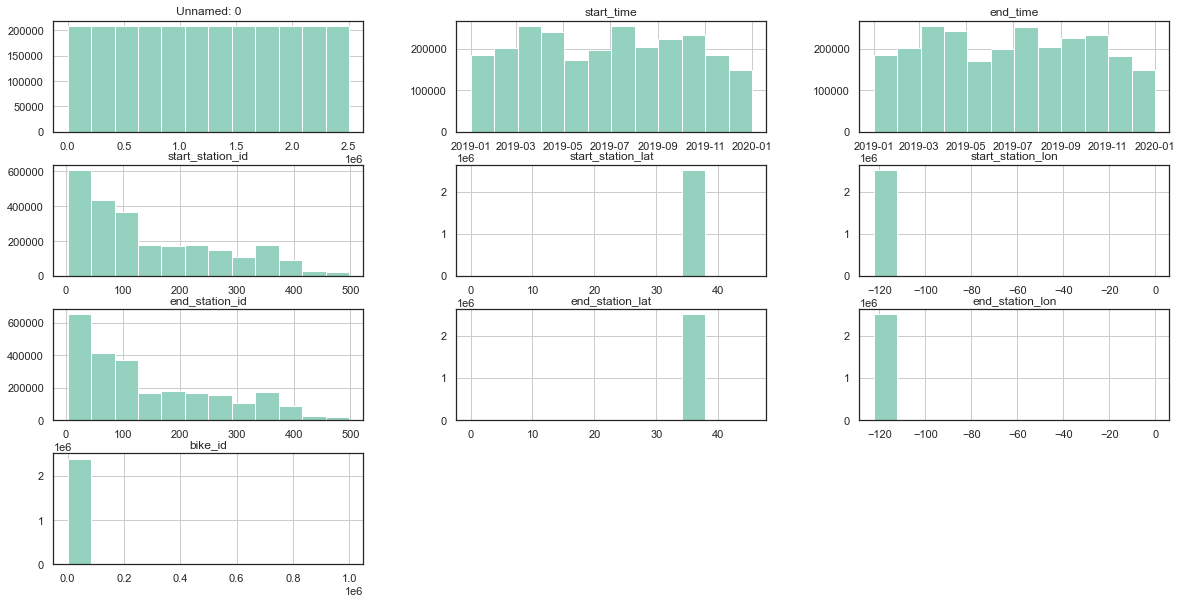

In [22]:
bikeRen.hist(bins = 12, figsize = (20, 10))

Something can be interpreted from the above graph:
the stations with the station_id under 150 are more occupied than the rest, maybe they are located within city center?




Now let's try to calculate idle time
2 approach: idle time group by bike_id, and idle time group by station_id

the first one is easier to implement, but the latter is actually more relevant to our project later on 

Let's go with the first approach first


In [68]:


# # Sort the data within each group by 'start_time' in ascending order
# sorted_bike_id_group = bike_id_group.apply(lambda x: x.sort_values('start_time'))

# # Reset the index of sorted_bike_id_group
# sorted_bike_id_group.reset_index(drop=True, inplace=True)

# Calculate idle time by subtracting the start time of entry (i+1) from the end time of entry (i)
bikeRen.sort_values(by='start_time',inplace= True)

bikeRen['bike_idle_time'] = bikeRen['start_time'] - bikeRen.groupby('bike_id')['end_time'].shift(1)


bikeRen.head(10)
bikeRen.sort_values(by='bike_id',inplace= False)

   
   

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,bike_idle_time
5,1153682,2019-11-28 15:02:41,2019-11-28 15:08:10,408,37.718027,-122.387862,408,37.718027,-122.387862,4,0 days 00:00:45
6,2482847,2019-11-28 14:59:39,2019-11-28 15:01:56,408,37.718027,-122.387862,408,37.718027,-122.387862,4,NaT
100,759693,2019-01-22 08:33:49,2019-01-22 08:37:58,3,37.786375,-122.404904,47,37.780955,-122.399749,11,0 days 00:18:18
77,2213013,2019-03-11 18:26:07,2019-03-11 18:35:38,81,37.775880,-122.393170,27,37.788059,-122.391865,11,0 days 00:33:52
183,1134069,2019-04-02 09:47:35,2019-04-02 09:53:49,71,37.773063,-122.439078,95,37.766219,-122.431060,11,1 days 01:36:31
...,...,...,...,...,...,...,...,...,...,...,...
2506973,117713,2019-12-03 15:15:09,2019-12-03 15:18:39,423,37.775696,-122.392793,344,37.775760,-122.392793,999941,0 days 00:17:40
2506985,1274746,2019-12-03 11:05:06,2019-12-03 11:07:02,423,37.775776,-122.392644,344,37.775815,-122.392665,999941,0 days 00:00:22
2506978,2419180,2019-12-03 11:03:38,2019-12-03 11:04:44,423,37.775767,-122.392613,344,37.775776,-122.392676,999941,0 days 00:37:47
2506972,1825484,2019-12-03 14:31:29,2019-12-03 14:33:29,423,37.775893,-122.392476,344,37.775898,-122.392490,999941,0 days 00:06:33


In [36]:
bikeRen=bikeRen.drop('idle_time',axis=1)

In [69]:
bikeRen.isna().sum()

Unnamed: 0               0
start_time               0
end_time                 0
start_station_id         0
start_station_lat        0
start_station_lon        0
end_station_id           0
end_station_lat          0
end_station_lon          0
bike_id                  0
bike_idle_time       11069
dtype: int64

In [70]:
bikeRen[bikeRen["bike_idle_time"].isnull()].sort_values(by='bike_id')

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,bike_idle_time
6,2482847,2019-11-28 14:59:39,2019-11-28 15:01:56,408,37.718027,-122.387862,408,37.718027,-122.387862,4,NaT
164,84754,2019-01-02 20:15:13,2019-01-02 20:40:58,155,37.840521,-122.293528,200,37.800214,-122.253810,11,NaT
358,2216522,2019-01-08 08:11:34,2019-01-08 08:16:29,158,37.833279,-122.263490,176,37.828410,-122.266315,12,NaT
1337,409483,2019-01-02 17:59:08,2019-01-02 18:05:50,163,37.797320,-122.265320,200,37.800214,-122.253810,13,NaT
1755,752761,2019-01-26 23:00:22,2019-01-26 23:03:18,240,37.866043,-122.258804,266,37.862464,-122.264791,14,NaT
...,...,...,...,...,...,...,...,...,...,...,...
2506884,148344,2019-11-22 10:11:48,2019-11-22 15:41:47,397,37.765891,-122.395667,164,37.799111,-122.457995,998086,NaT
2506903,1989345,2019-07-23 20:39:19,2019-07-23 20:43:33,93,37.770407,-122.391198,345,37.766483,-122.398279,998430,NaT
2506948,1648125,2019-07-11 16:46:20,2019-07-11 16:49:16,425,37.774553,-122.414245,425,37.774589,-122.414209,999422,NaT
2506970,264914,2019-11-06 14:15:22,2019-11-06 14:16:37,175,37.774500,-122.414023,237,37.774578,-122.413950,999937,NaT


I suppose the rows with NaT are the earliest entry of every bike, i.e they dont have any idle time. So I'll fill them with 0 for now

In [71]:
bikeRen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506978 entries, 1440582 to 2392415
Data columns (total 11 columns):
 #   Column             Dtype          
---  ------             -----          
 0   Unnamed: 0         int64          
 1   start_time         datetime64[ns] 
 2   end_time           datetime64[ns] 
 3   start_station_id   int64          
 4   start_station_lat  float64        
 5   start_station_lon  float64        
 6   end_station_id     int64          
 7   end_station_lat    float64        
 8   end_station_lon    float64        
 9   bike_id            int64          
 10  bike_idle_time     timedelta64[ns]
dtypes: datetime64[ns](2), float64(4), int64(4), timedelta64[ns](1)
memory usage: 229.5 MB


In [73]:
bikeRen['bike_idle_time']= bikeRen['bike_idle_time'].fillna(pd.Timedelta(0))
bikeRen.sort_values(by="bike_id",inplace=True)
bikeRen

,Unnamed: 0,start_time,end_time,start_station_id,start_station_lat,start_station_lon,end_station_id,end_station_lat,end_station_lon,bike_id,bike_idle_time
5,1153682,2019-11-28 15:02:41,2019-11-28 15:08:10,408,37.718027,-122.387862,408,37.718027,-122.387862,4,0 days 00:00:45
6,2482847,2019-11-28 14:59:39,2019-11-28 15:01:56,408,37.718027,-122.387862,408,37.718027,-122.387862,4,0 days 00:00:00
139,2307933,2019-04-24 18:36:47,2019-04-24 18:45:03,89,37.769218,-122.407646,92,37.772301,-122.393028,11,0 days 00:38:46
179,220849,2019-02-12 11:51:17,2019-02-12 11:58:30,44,37.781074,-122.411738,88,37.770030,-122.411726,11,0 days 03:24:52
64,548391,2019-01-19 15:03:23,2019-01-19 15:11:14,118,37.759177,-122.436943,109,37.763316,-122.421904,11,3 days 06:15:41
...,...,...,...,...,...,...,...,...,...,...,...
2506982,813813,2019-12-08 01:15:35,2019-12-08 01:16:41,423,37.775925,-122.392526,344,37.776050,-122.392549,999941,4 days 09:31:23
2506973,117713,2019-12-03 15:15:09,2019-12-03 15:18:39,423,37.775696,-122.392793,344,37.775760,-122.392793,999941,0 days 00:17:40
2506985,1274746,2019-12-03 11:05:06,2019-12-03 11:07:02,423,37.775776,-122.392644,344,37.775815,-122.392665,999941,0 days 00:00:22
2506978,2419180,2019-12-03 11:03:38,2019-12-03 11:04:44,423,37.775767,-122.392613,344,37.775776,-122.392676,999941,0 days 00:37:47


Now with the second approach its harder to extract the station_id to group, because each row has 2 station_id(start/end). 